## Compute NEO Ephemerides for AuxTel

This notebook computes the ephemerides of bright, fast(-ish) moving NEOs, and outputs the results in the format needed by AuxTel's manual observing system.

It's a one-off piece of code needed to get the MPC Obscode for AuxTel (see https://jira.lsstcorp.org/browse/SITCOM-1192).

If run from `mjuric`'s usual \~/projects/github.com directory on epyc, the outputs should be visible in https://epyc.astro.washington.edu/~mjuric/auxtel-ephems

The inputs: asteroids monitored each night, identified using https://minorplanetcenter.net/cgi-bin/neaobs.cgi .

Retrieved on Feb 13th, 2024.

In [246]:
inputs = \
{
    '2024-02-13': [136874, 483508, 4055, '2016 AX147', 418929, 523811, 18172, 10165], # Tue
    '2024-02-14': [136874, 483508, '2016 AX147', 418929, 523811, 18172, 10165, 138883], # Wed
    '2024-02-15': ['2024 CG2', 136874, 483508, '2016 AX147', 418929, 18172, 10165, 523811, 138883], # Thu
    '2024-02-16': [136874, '2024 CG2', 483508, '2016 AX147', 418929, 18172, 10165, 523811, 138883] # Fri
}

### Function computing.writing the observation files for a single asteroid & night

In [164]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astroquery.jplhorizons import Horizons
from astropy.coordinates import SkyCoord
import datetime
import os

In [188]:
#obj = Horizons(id='2024 CG2', location='X05', epochs={'start':'2024-02-14 23:00:00', 'stop':'2024-02-15 09:00:00', 'step':'1hour'})
obj = Horizons(id='2016 AX147', location='X05', epochs={'start':'2024-02-14 23:00:00', 'stop':'2024-02-15 09:00:00', 'step':'1hour'})
eph = obj.ephemerides()

In [189]:
eph

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,mag,---,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str12,str17,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,str1,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
(2016 AX147),2024-Feb-14 23:00,2460355.458333333,17.68,0.15,*,m,191.15705,-23.24128,191.47917,-23.37307,83.442,-114.038,134.256683,-19.791811,-609.63,558.85,-478988.16,-37567.36,229.696,3.9143458226,999.0,--,18.407,--,89.73801,--,446680.2,*,--,--,--,--,--,125.93,0.0,--,--,162.8509,-6.4282,1.3477665454,-11.4454247,0.51776215546789,-15.8700414,4.30609654,30.9480388,21.6586823,124.0778,/L,37.3703,159.5,32.0296,18.2437,305.964,294.353,7.36924,Hya,69.185079,199.8867437,-16.93686,--,--,300.906115,39.603661,18.0478750702,0.000354,0.284,0.173,0.299,0.145,-21.233,0.1361235,0.332,63.8607,1.83e-05,0.23,0.83,0.000426,297.1212,-8.8509321,37.3674,180.8355,-12.2894
(2016 AX147),2024-Feb-15 00:00,2460355.5,17.68,0.15,N,m,191.18216,-23.27302,191.50433,-23.40479,82.67508,-114.362,124.508226,-9.731899,-520.34,642.58,-479070.31,-37733.16,229.662,4.9170836938,999.0,--,18.405,--,89.73349,--,446688.2,*,--,--,--,--,--,125.95,0.0,--,--,162.8802,-6.432,1.347491138462,-11.442413,0.51737970600153,-15.9127031,4.30291581,30.9523855,21.6691636,124.0801,/L,37.3789,159.3,32.3247,18.2329,305.98,294.34,7.38748,Hya,69.18508,199.9223044,-16.9564172,--,--,300.937445,39.572732,19.0478973505,0.000354,0.284,0.173,0.299,0.145,-21.217,0.1363678,0.333,63.8548,1.83e-05,0.23,0.83,0.000426,297.1506,-7.849871745,37.3759,180.8669,-12.3018
(2016 AX147),2024-Feb-15 01:00,2460355.541666667,17.68,0.15,,m,191.20701,-23.30483,191.52925,-23.43659,81.78357,-114.594,116.461269,1.469908,-443.16,697.83,-479153.77,-37899.24,229.628,5.9198215667,20.605,2.875,18.403,--,89.72905,--,446697.1,*,--,--,--,--,--,125.96,0.0,--,--,162.9096,-6.4359,1.347215804024,-11.4393971,0.51699649231525,-15.9330492,4.29972871,30.9567323,21.6533315,124.0825,/L,37.3873,159.0,32.645,18.2221,305.997,294.328,7.40589,Hya,69.185081,199.957684,-16.9761402,--,--,300.968447,39.541704,20.0479102964,0.000354,0.284,0.173,0.3,0.145,-21.201,0.1366132,0.333,63.8487,1.83e-05,0.23,0.83,0.000426,297.1801,-6.848795134,37.3843,180.8983,-12.3144
(2016 AX147),2024-Feb-15 02:00,2460355.583333333,17.68,0.15,,m,191.23159,-23.33669,191.5539,-23.46844,80.83172,-114.725,109.558385,13.425434,-379.23,734.33,-479238.6,-38065.47,229.594,6.9225594415,4.215,0.588,18.402,-

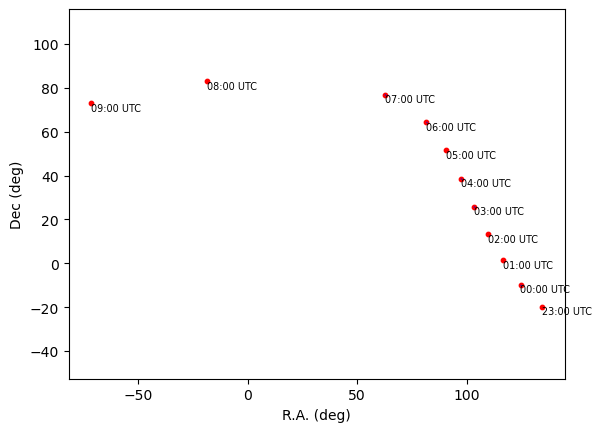

In [190]:
# https://noirlab.edu/public/programs/vera-c-rubin-observatory/rubin-auxtel/
a = (eph["RA"], eph["DEC"], eph["datetime_str"])

if True:
    az, el = (eph["AZ"].copy(), eph["EL"].copy())
    az[az > 180] -= 360
    a = (az, el, eph["datetime_str"])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a[0], a[1], color = 'red', s=10)

# Add rectangles
width = 6.7/60
height = 6.7/60
for a_x, a_y, tstr in zip(*a):
    ax.add_patch(Rectangle(
        xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
        linewidth=1, color='blue', fill=False))
    ax.text(a_x - 0.48*width, a_y + 0.48*height, tstr.split(' ')[-1] + " UTC", size='x-small', verticalalignment='top')
ax.axis('equal')
ax.set_xlabel("R.A. (deg)")
ax.set_ylabel("Dec (deg)")
plt.show()

night-2024-02-14/2024-Feb-17_02:00UTC/138883 (2000 YL29).V=18.947.txt
night-2024-02-14/2024-Feb-17_03:00UTC/138883 (2000 YL29).V=18.946.txt
night-2024-02-14/2024-Feb-17_04:00UTC/138883 (2000 YL29).V=18.945.txt
night-2024-02-14/2024-Feb-17_05:00UTC/138883 (2000 YL29).V=18.944.txt
night-2024-02-14/2024-Feb-17_06:00UTC/138883 (2000 YL29).V=18.943.txt
night-2024-02-14/2024-Feb-17_07:00UTC/138883 (2000 YL29).V=18.942.txt
night-2024-02-14/2024-Feb-17_08:00UTC/138883 (2000 YL29).V=18.94.txt


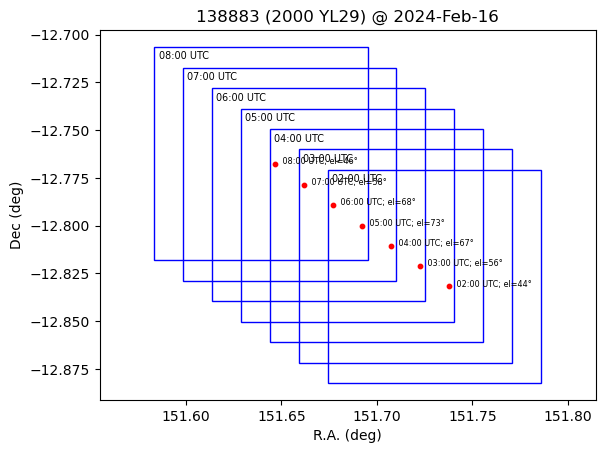

In [244]:
def create_sequence(eph, night, minel=40):
    m = eph["EL"] > 40
    a = (eph["RA"][m], eph["DEC"][m], eph["datetime_str"][m], eph["EL"][m])
    targetname = eph["targetname"][0]
    if targetname.startswith('('):
        targetname = targetname[1:-1]

    # Plot asteroid positions
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(a[0], a[1], color = 'red', s=10)
    for i, (a_x, a_y, txt, el) in enumerate(zip(*a)):
    #    ax.annotate('   ' + str(i+1), (a_x, a_y), size='xx-small')
        ax.annotate('   ' + txt.split()[-1] + f" UTC; el={el:.0f}°", (a_x, a_y), size='xx-small')

    # Compute fields & plot rectangles
    ra, dec = eph["RA"], eph["DEC"]

    coord1 = SkyCoord(ra[:-1], dec[0:-1], frame='icrs')
    coord2 = SkyCoord(ra[1:], dec[1:], frame='icrs')
    pa = coord1.position_angle(coord2)
    sep = coord1.separation(coord2)
    midpts = coord1.directional_offset_by(pa, sep/2)  

    a = (midpts.ra.degree, midpts.dec.degree, eph["datetime_str"][:-1], eph["EL"][:-1])
    width = 6.7/60
    height = 6.7/60
    for a_x, a_y, tstr, el in zip(*a):
        if el > minel:
            ax.add_patch(Rectangle(
                xy=(a_x-width/2, a_y-height/2) ,width=width, height=height,
                linewidth=1, color='blue', fill=False))
            ax.text(a_x - 0.48*width, a_y + 0.48*height, tstr.split(' ')[-1] + " UTC", size='x-small', verticalalignment='top')
    ax.axis('equal')
    ax.set_xlabel("R.A. (deg)")
    ax.set_ylabel("Dec (deg)")
    ax.set_title(targetname + " @ " + eph["datetime_str"][0].split()[0]);

    os.makedirs(f'night-{night}', exist_ok=True)
    fn = f'night-{night}/fields-{targetname}.png'
    fig.savefig(fn)

    # dump an observation file
    # For format, see https://jira.lsstcorp.org/browse/SITCOM-1192
    for ra, dec, V, tstr, el in zip(
        midpts.ra.to_string(u.hour, sep=":", precision=0, pad=True),
        midpts.dec.to_string(u.deg, sep=":", precision=0, alwayssign=True, pad=True),
        eph["V"][:-1],
        eph["datetime_str"][:-1],
        eph["EL"][:-1],
    ):
        if el > minel:
            subdir = f'night-{night}/{tstr.replace(' ', '_')}UTC'
            os.makedirs(subdir, exist_ok=True)
            fn = f'{subdir}/{targetname}.V={V}.txt'
            print(fn)

            with open(fn, "w") as fp:
                print( "ra (hour) dec (deg) Nexp ExpTime Filter", file=fp)
                print(f" {ra} {dec}    5    15.0      r", file=fp)
                print(f" {ra} {dec}    5    30.0      r", file=fp)
                print(f" {ra} {dec}    2    60.0      r", file=fp)
                print(f" {ra} {dec}    1   120.0      r", file=fp)

create_sequence(eph, '2024-02-14')

## Now loop for all inputs

Cache JPL calls so Steve doesn't send bombers our way...

In [193]:
cache = {}

Fetching (136874, '2024-02-13', '2024-02-14')
night-2024-02-13/2024-Feb-14_05:00UTC/136874 (1998 FH74).V=17.53.txt
night-2024-02-13/2024-Feb-14_06:00UTC/136874 (1998 FH74).V=17.529.txt
night-2024-02-13/2024-Feb-14_07:00UTC/136874 (1998 FH74).V=17.529.txt
night-2024-02-13/2024-Feb-14_08:00UTC/136874 (1998 FH74).V=17.529.txt
Fetching (483508, '2024-02-13', '2024-02-14')
night-2024-02-13/2024-Feb-14_02:00UTC/483508 (2003 CR1).V=17.937.txt
night-2024-02-13/2024-Feb-14_03:00UTC/483508 (2003 CR1).V=17.94.txt
night-2024-02-13/2024-Feb-14_04:00UTC/483508 (2003 CR1).V=17.944.txt
night-2024-02-13/2024-Feb-14_05:00UTC/483508 (2003 CR1).V=17.947.txt
night-2024-02-13/2024-Feb-14_06:00UTC/483508 (2003 CR1).V=17.95.txt
night-2024-02-13/2024-Feb-14_07:00UTC/483508 (2003 CR1).V=17.953.txt
night-2024-02-13/2024-Feb-14_08:00UTC/483508 (2003 CR1).V=17.957.txt
Fetching (4055, '2024-02-13', '2024-02-14')
night-2024-02-13/2024-Feb-14_01:00UTC/4055 Magellan (1985 DO2).V=18.362.txt
night-2024-02-13/2024-Feb-14

/tmp/ipykernel_129279/1737438902.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


night-2024-02-15/2024-Feb-16_02:00UTC/418929 (2009 DM1).V=18.586.txt
night-2024-02-15/2024-Feb-16_03:00UTC/418929 (2009 DM1).V=18.586.txt
night-2024-02-15/2024-Feb-16_04:00UTC/418929 (2009 DM1).V=18.587.txt
night-2024-02-15/2024-Feb-16_05:00UTC/418929 (2009 DM1).V=18.588.txt
night-2024-02-15/2024-Feb-16_06:00UTC/418929 (2009 DM1).V=18.588.txt
night-2024-02-15/2024-Feb-16_07:00UTC/418929 (2009 DM1).V=18.589.txt
night-2024-02-15/2024-Feb-16_08:00UTC/418929 (2009 DM1).V=18.589.txt
night-2024-02-15/2024-Feb-16_05:00UTC/18172 (2000 QL7).V=18.562.txt
night-2024-02-15/2024-Feb-16_06:00UTC/18172 (2000 QL7).V=18.561.txt
night-2024-02-15/2024-Feb-16_07:00UTC/18172 (2000 QL7).V=18.561.txt
night-2024-02-15/2024-Feb-16_08:00UTC/18172 (2000 QL7).V=18.56.txt
night-2024-02-15/2024-Feb-16_03:00UTC/10165 (1995 BL2).V=18.574.txt
night-2024-02-15/2024-Feb-16_04:00UTC/10165 (1995 BL2).V=18.572.txt
night-2024-02-15/2024-Feb-16_05:00UTC/10165 (1995 BL2).V=18.571.txt
night-2024-02-15/2024-Feb-16_06:00UTC/1016

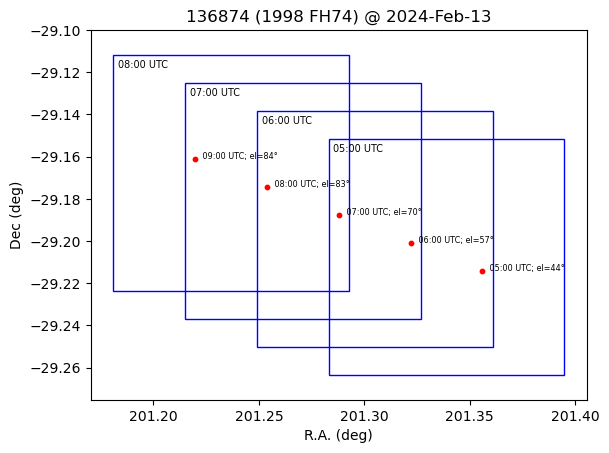

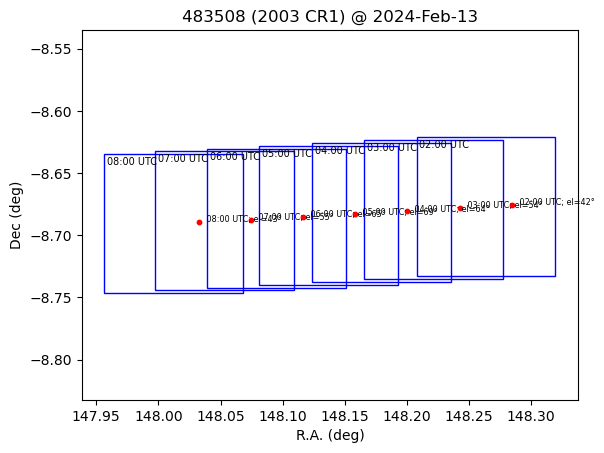

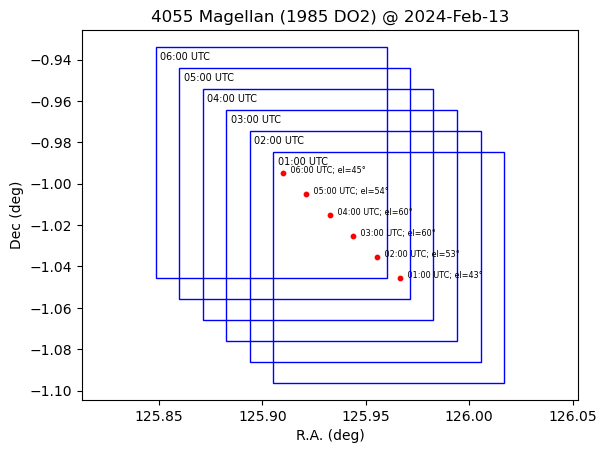

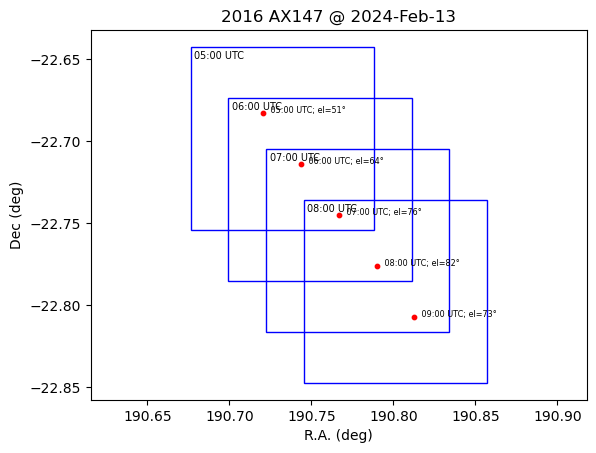

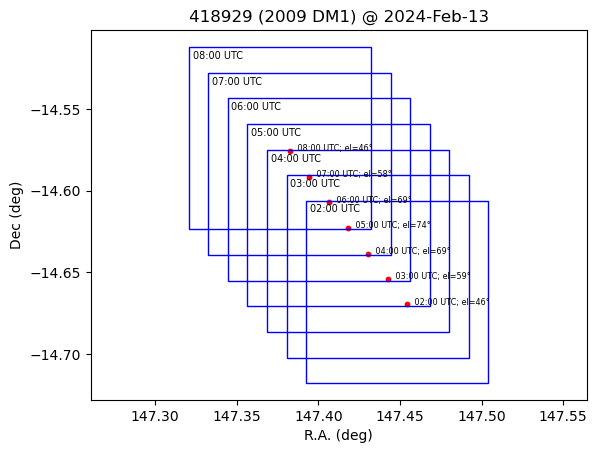

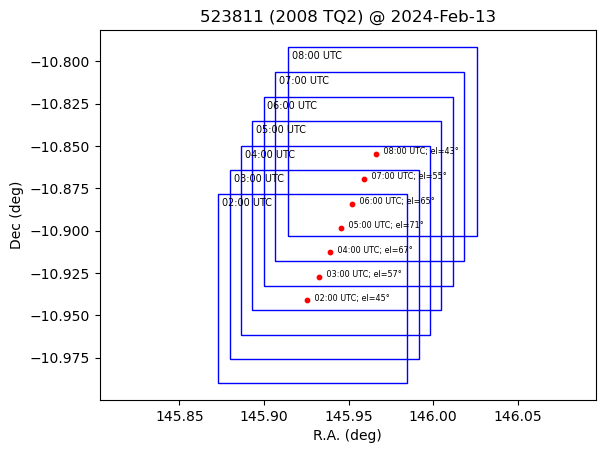

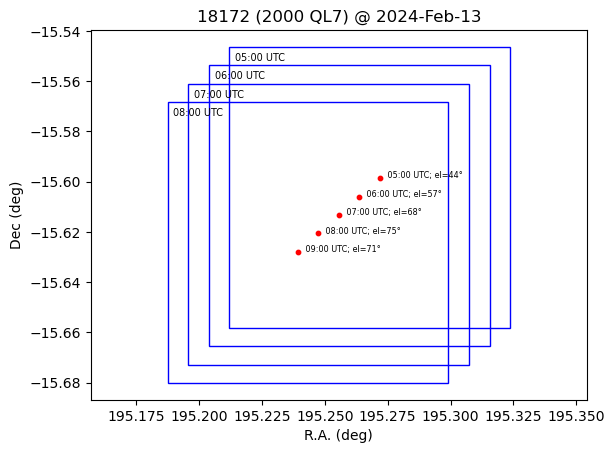

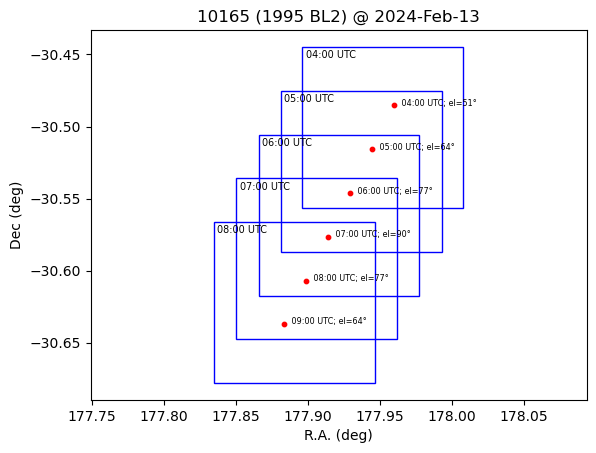

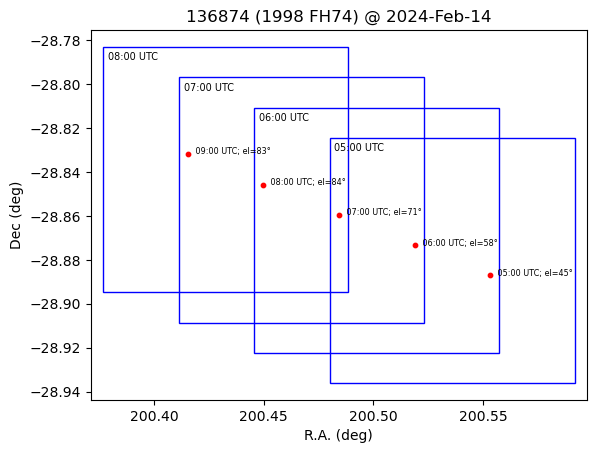

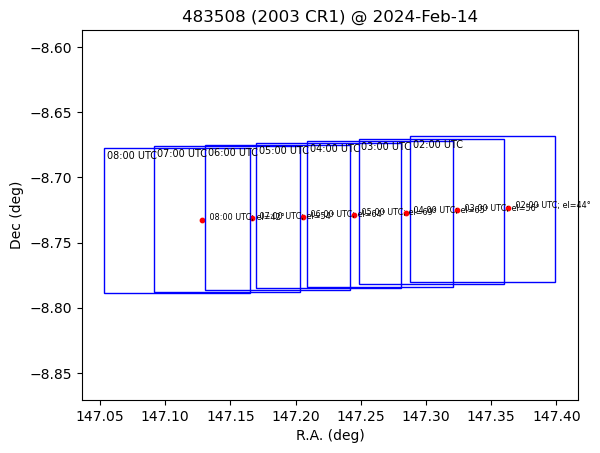

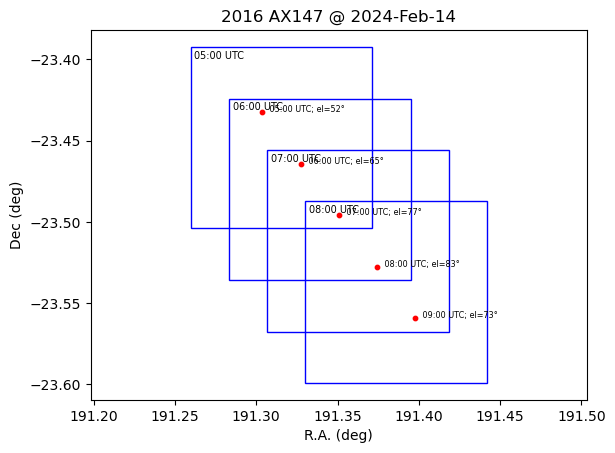

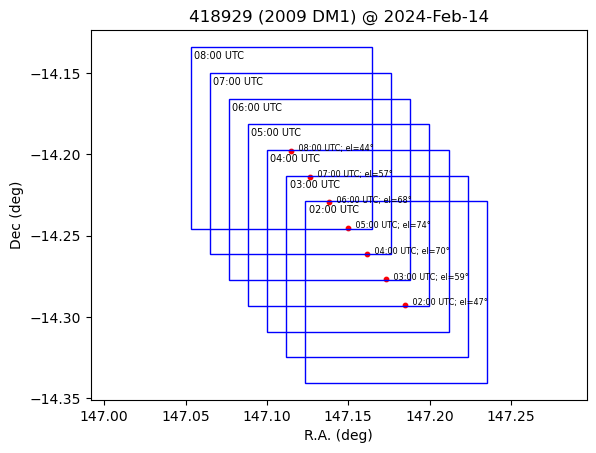

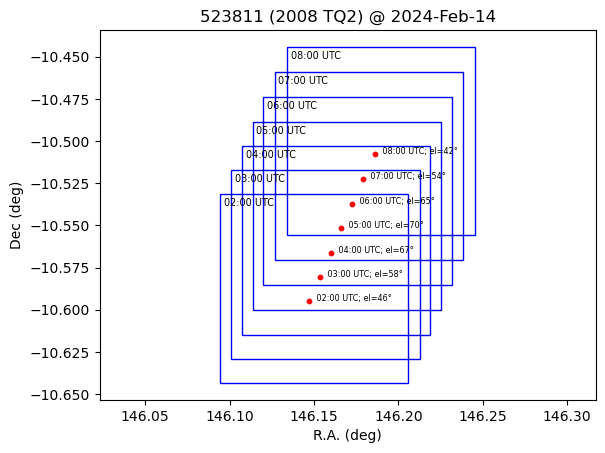

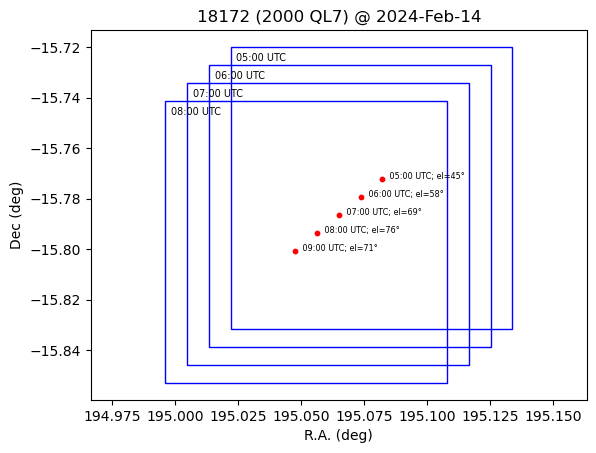

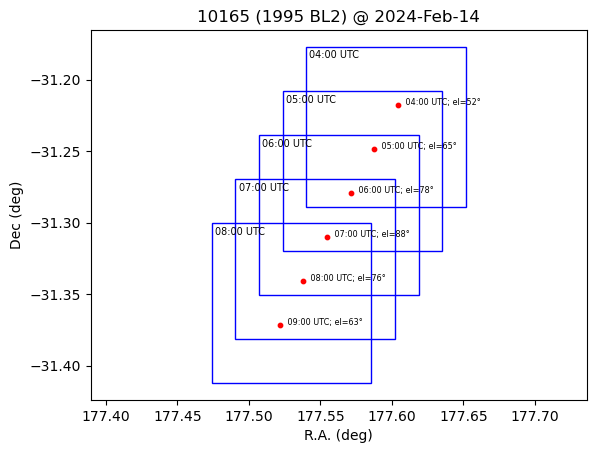

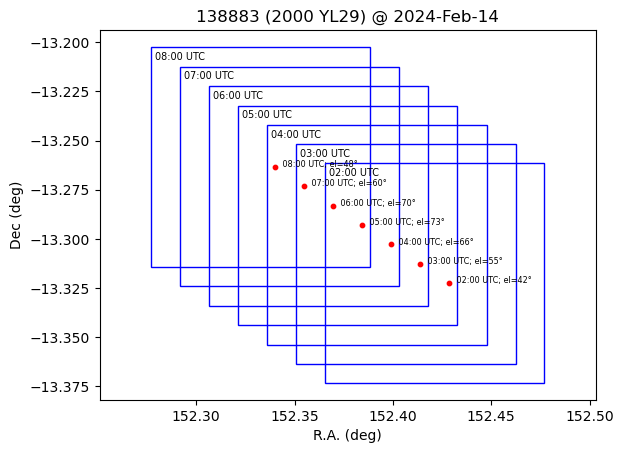

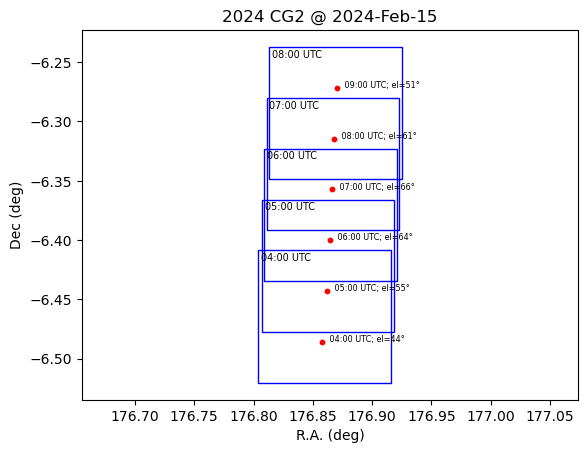

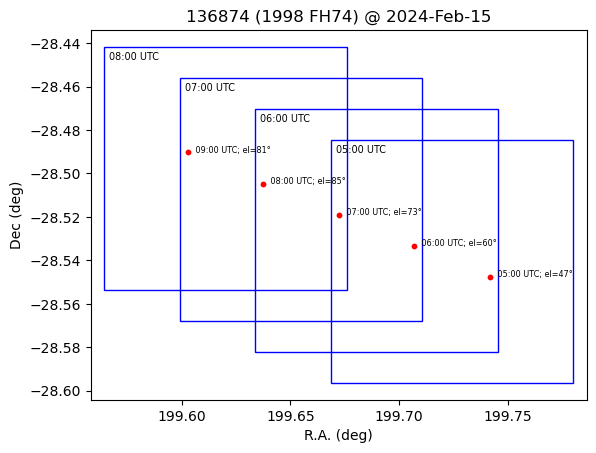

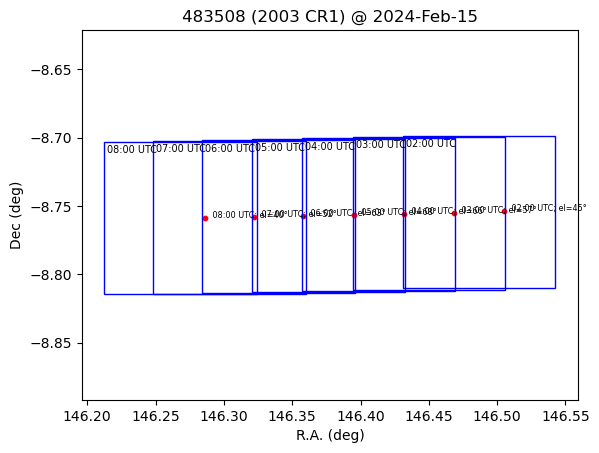

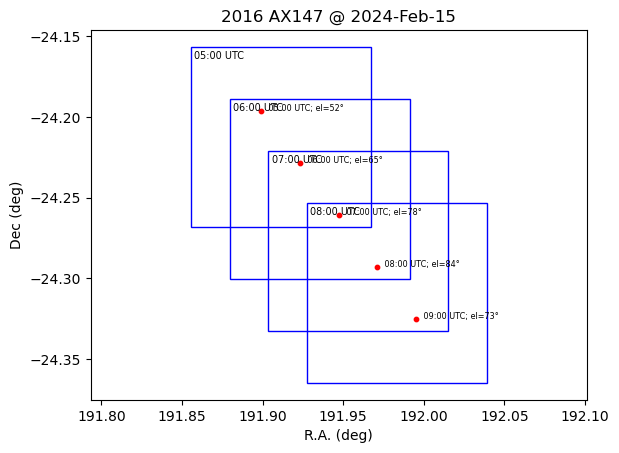

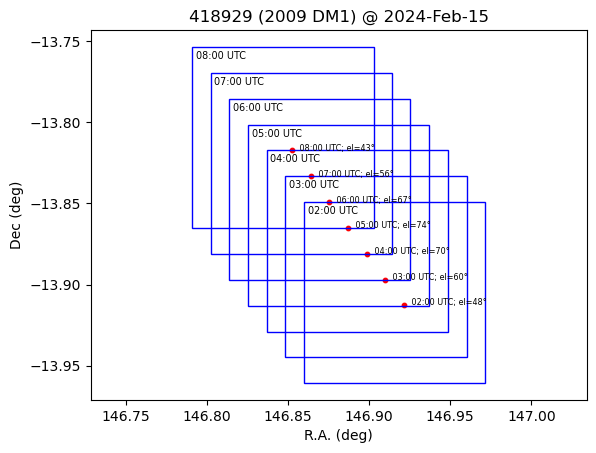

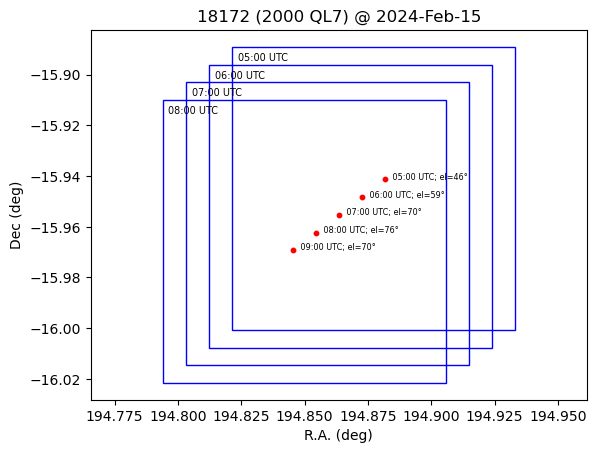

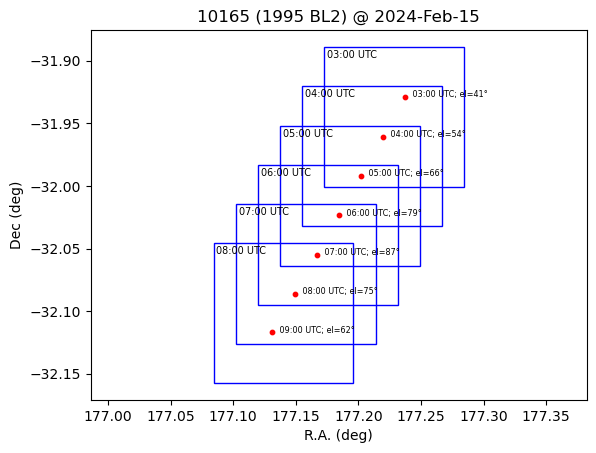

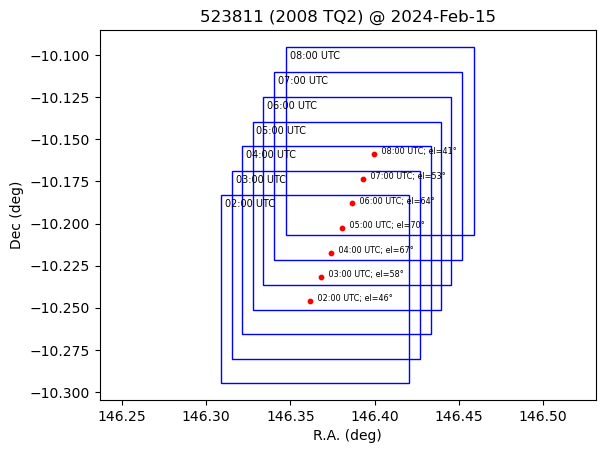

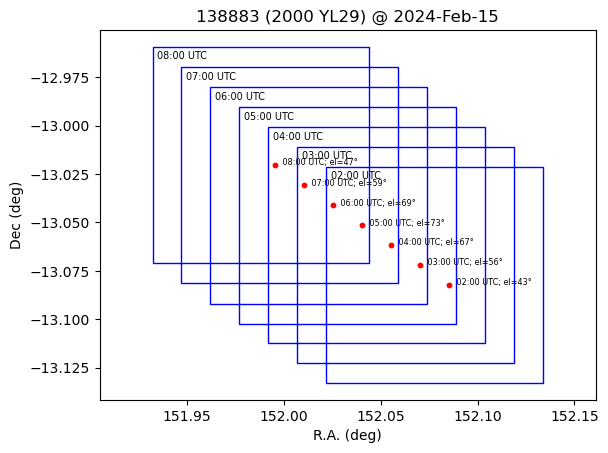

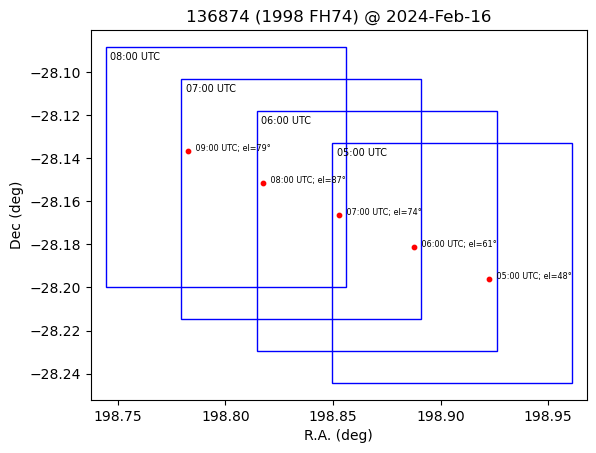

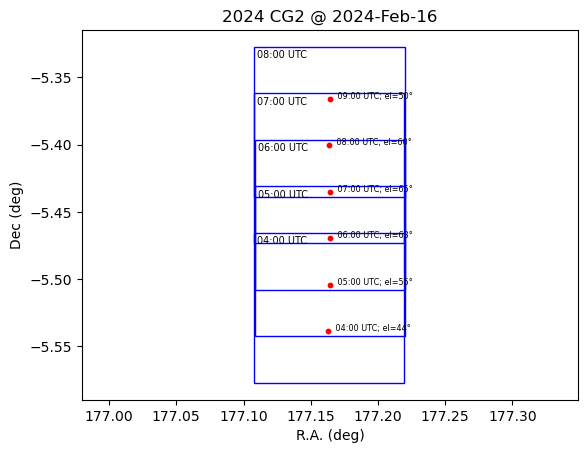

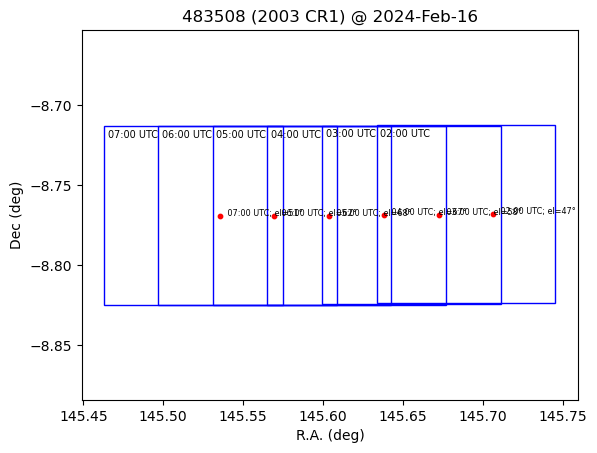

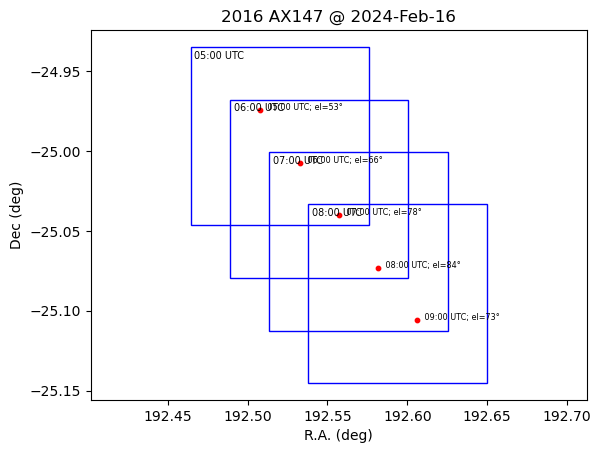

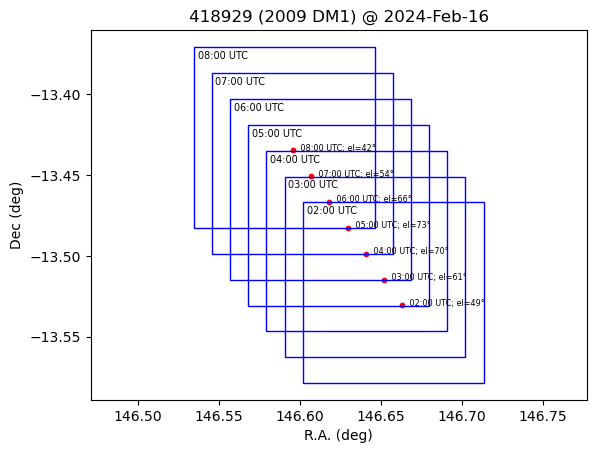

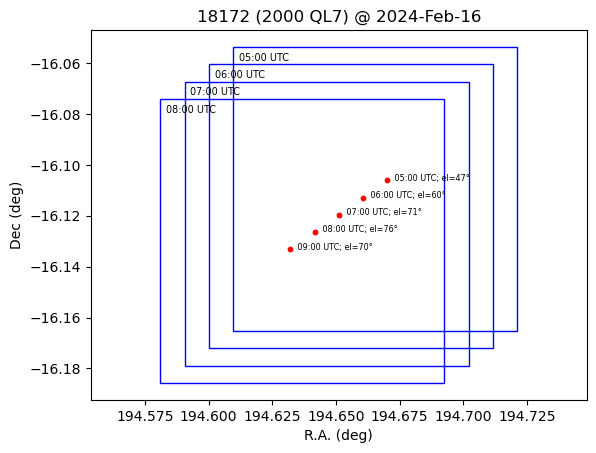

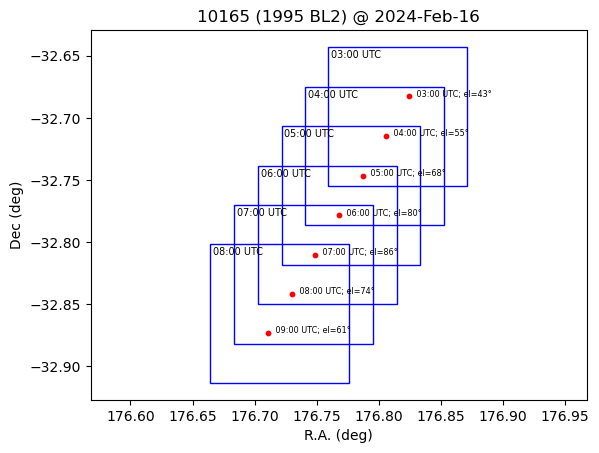

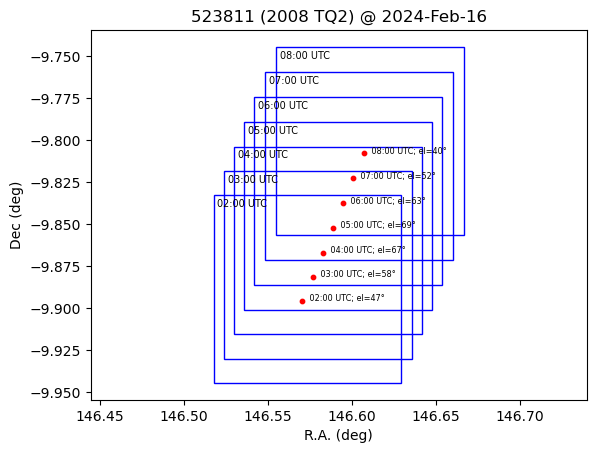

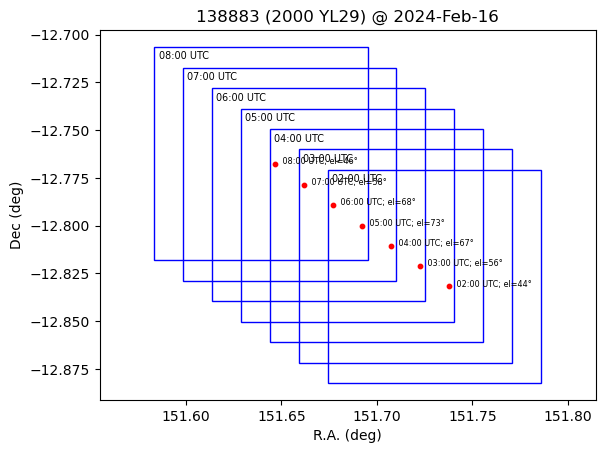

In [247]:
for night, targets in inputs.items():
    for target in targets:
        night_stop = (datetime.date.fromisoformat(night) + datetime.timedelta(days=1)).isoformat()
        key = (target, night, night_stop)
        if key not in cache:
            print(f"Fetching {key}")
            obj = Horizons(id=target, location='X05', epochs={'start':f'{night} 23:00:00', 'stop':f'{night_stop} 09:00:00', 'step':'1hour'})
            cache[key] = obj.ephemerides()
        eph = cache[key]
        
        create_sequence(eph, night)

## Per-hour summary plots

These are useful to glance at what's visible each hour.

night-2024-02-14/2024-Feb-15_02:00UTC/483508 (2003 CR1).V=18.016.txt
night-2024-02-14/2024-Feb-15_02:00UTC/418929 (2009 DM1).V=18.573.txt
night-2024-02-14/2024-Feb-15_02:00UTC/523811 (2008 TQ2).V=18.686.txt
night-2024-02-14/2024-Feb-15_02:00UTC/138883 (2000 YL29).V=19.004.txt
night-2024-02-14/2024-Feb-15_02:00UTC/targets.png
night-2024-02-14/2024-Feb-15_03:00UTC/483508 (2003 CR1).V=18.019.txt
night-2024-02-14/2024-Feb-15_03:00UTC/418929 (2009 DM1).V=18.574.txt
night-2024-02-14/2024-Feb-15_03:00UTC/523811 (2008 TQ2).V=18.687.txt
night-2024-02-14/2024-Feb-15_03:00UTC/138883 (2000 YL29).V=19.003.txt
night-2024-02-14/2024-Feb-15_03:00UTC/targets.png
night-2024-02-14/2024-Feb-15_04:00UTC/483508 (2003 CR1).V=18.023.txt
night-2024-02-14/2024-Feb-15_04:00UTC/418929 (2009 DM1).V=18.574.txt
night-2024-02-14/2024-Feb-15_04:00UTC/523811 (2008 TQ2).V=18.688.txt
night-2024-02-14/2024-Feb-15_04:00UTC/10165 (1995 BL2).V=18.618.txt
night-2024-02-14/2024-Feb-15_04:00UTC/138883 (2000 YL29).V=19.002.txt
n

/tmp/ipykernel_129279/4047797179.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


night-2024-02-16/2024-Feb-17_03:00UTC/483508 (2003 CR1).V=18.184.txt
night-2024-02-16/2024-Feb-17_03:00UTC/418929 (2009 DM1).V=18.601.txt
night-2024-02-16/2024-Feb-17_03:00UTC/10165 (1995 BL2).V=18.529.txt
night-2024-02-16/2024-Feb-17_03:00UTC/523811 (2008 TQ2).V=18.741.txt
night-2024-02-16/2024-Feb-17_03:00UTC/138883 (2000 YL29).V=18.946.txt
night-2024-02-16/2024-Feb-17_03:00UTC/targets.png
night-2024-02-16/2024-Feb-17_04:00UTC/2024 CG2.V=17.904.txt
night-2024-02-16/2024-Feb-17_04:00UTC/483508 (2003 CR1).V=18.187.txt
night-2024-02-16/2024-Feb-17_04:00UTC/418929 (2009 DM1).V=18.601.txt
night-2024-02-16/2024-Feb-17_04:00UTC/10165 (1995 BL2).V=18.527.txt
night-2024-02-16/2024-Feb-17_04:00UTC/523811 (2008 TQ2).V=18.743.txt
night-2024-02-16/2024-Feb-17_04:00UTC/138883 (2000 YL29).V=18.945.txt
night-2024-02-16/2024-Feb-17_04:00UTC/targets.png
night-2024-02-16/2024-Feb-17_05:00UTC/136874 (1998 FH74).V=17.509.txt
night-2024-02-16/2024-Feb-17_05:00UTC/2024 CG2.V=17.912.txt
night-2024-02-16/202

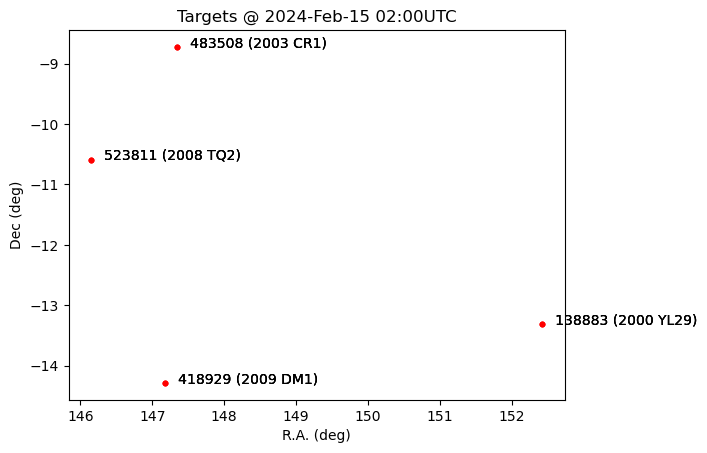

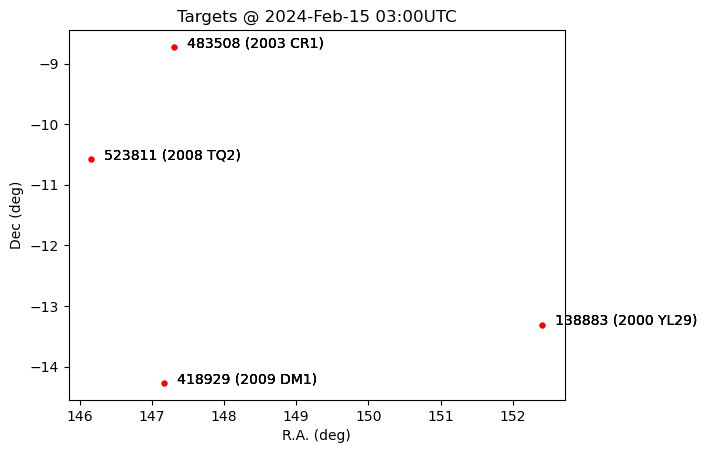

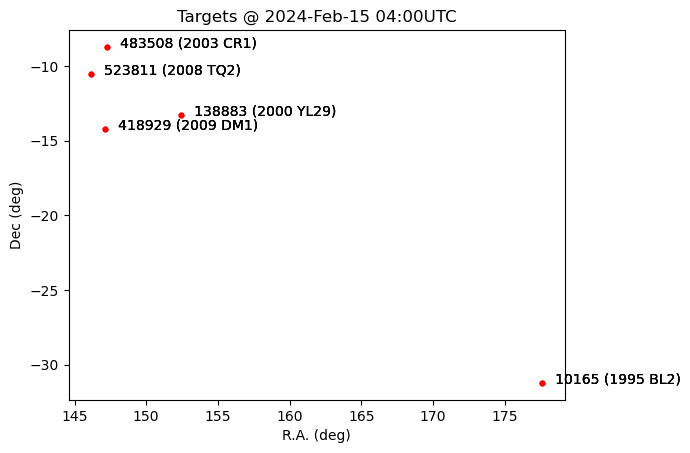

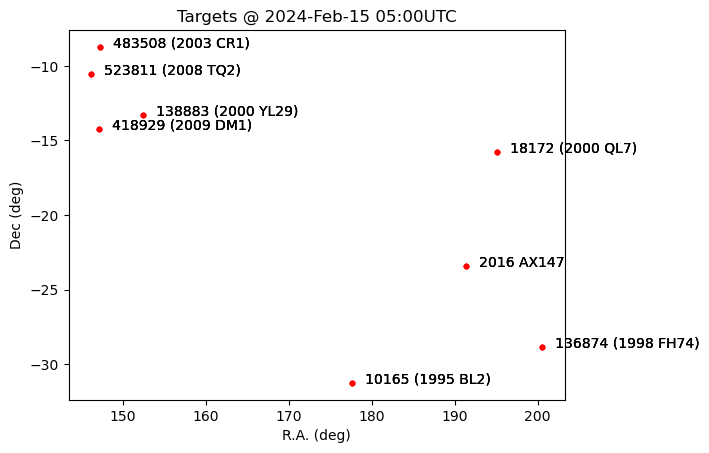

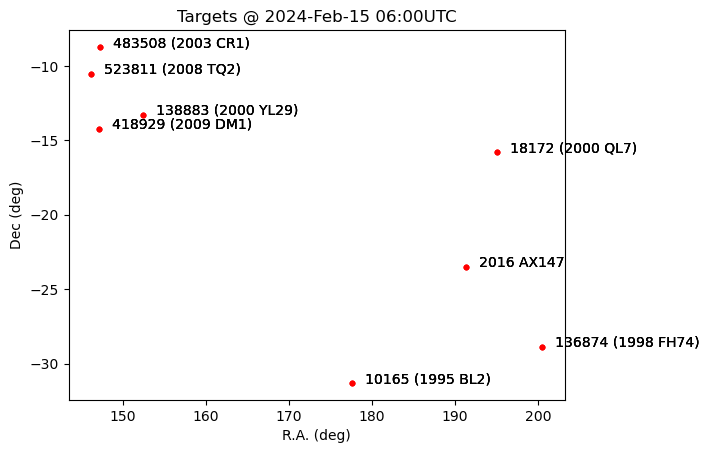

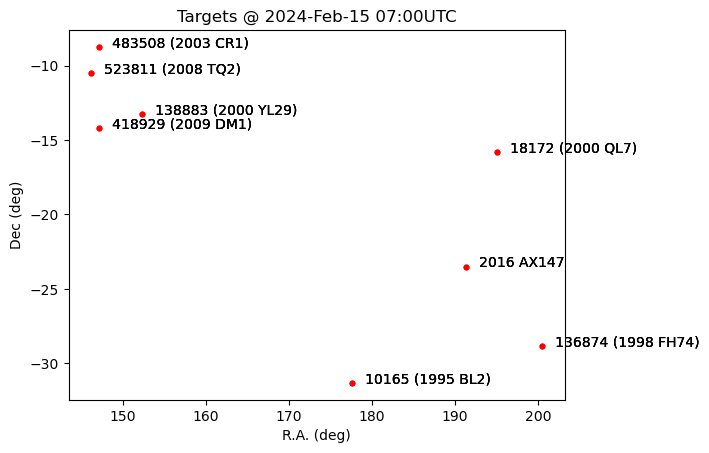

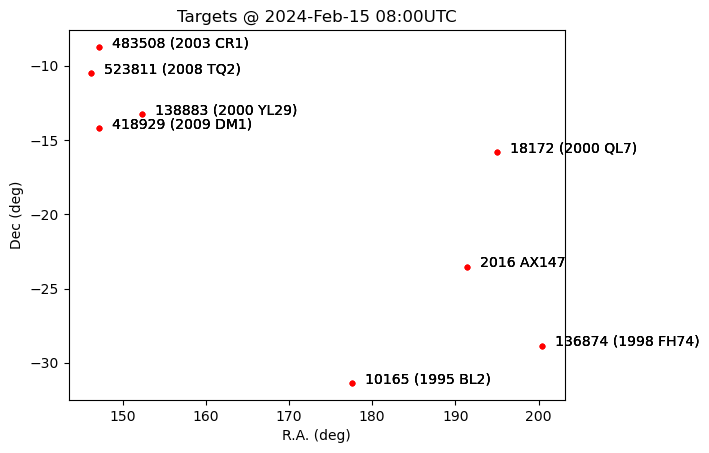

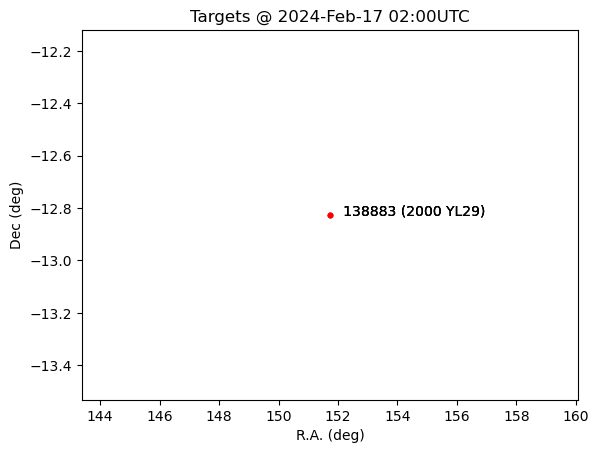

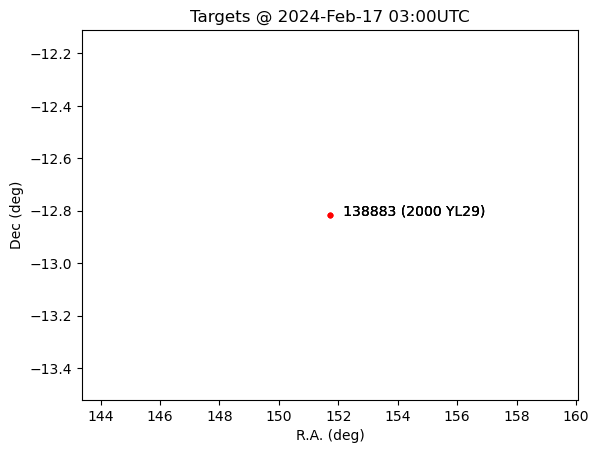

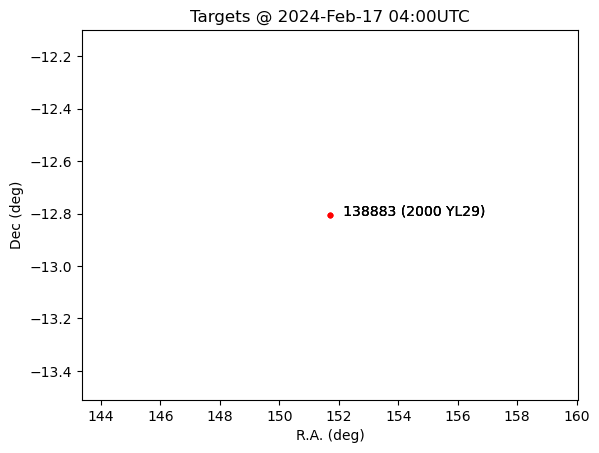

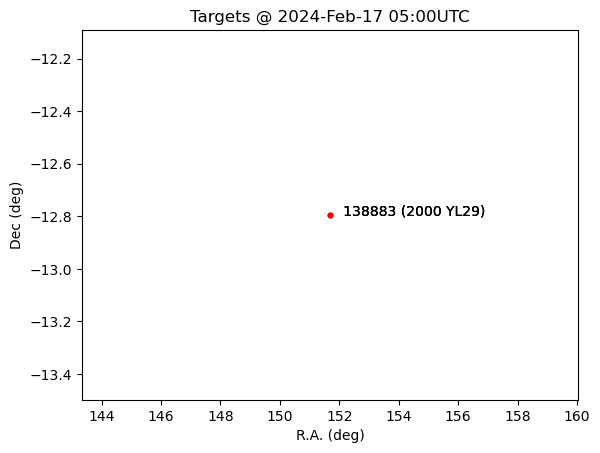

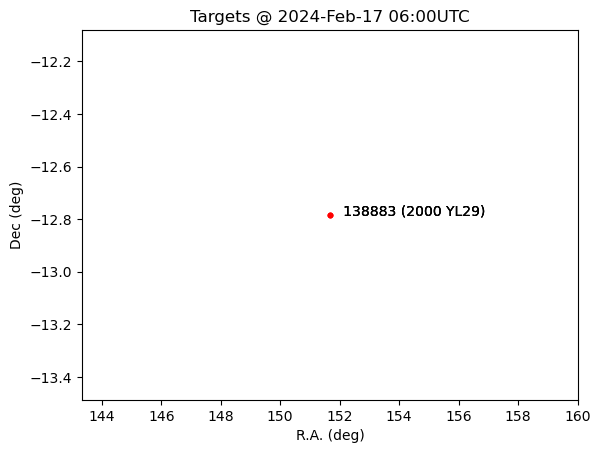

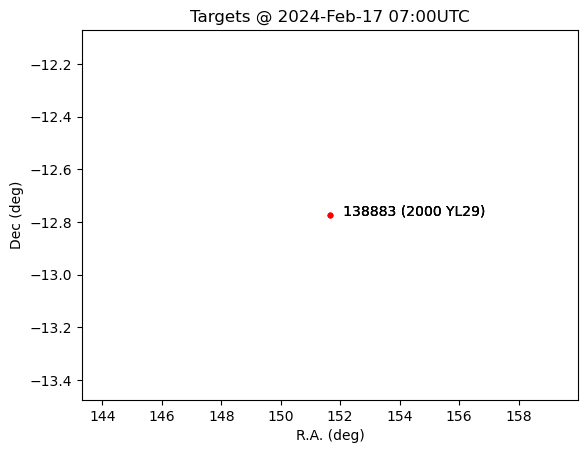

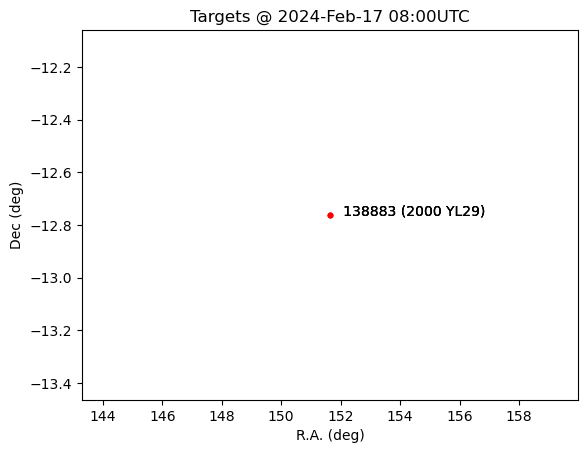

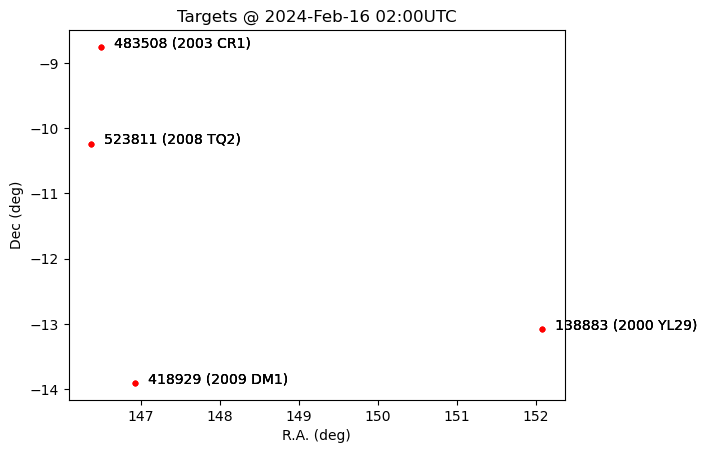

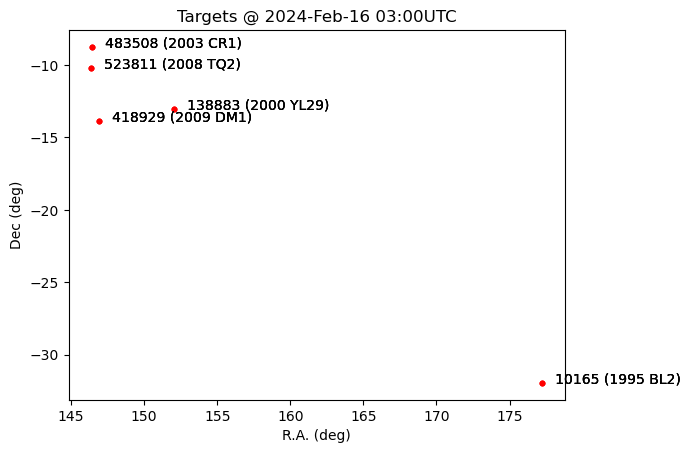

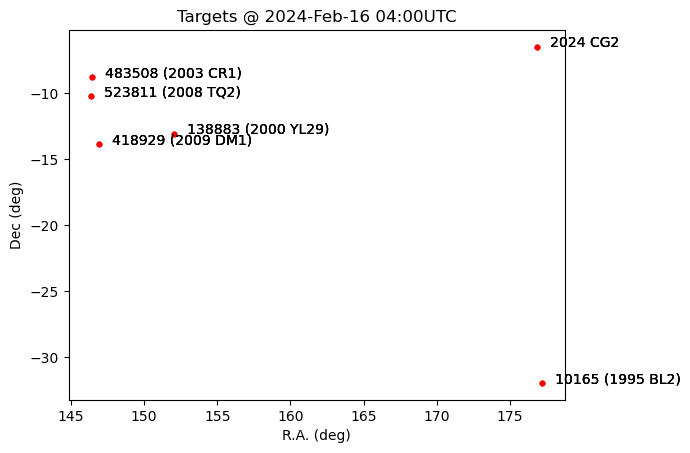

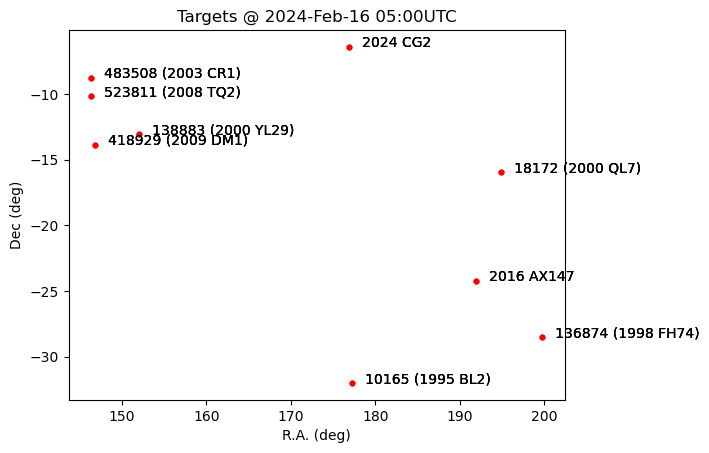

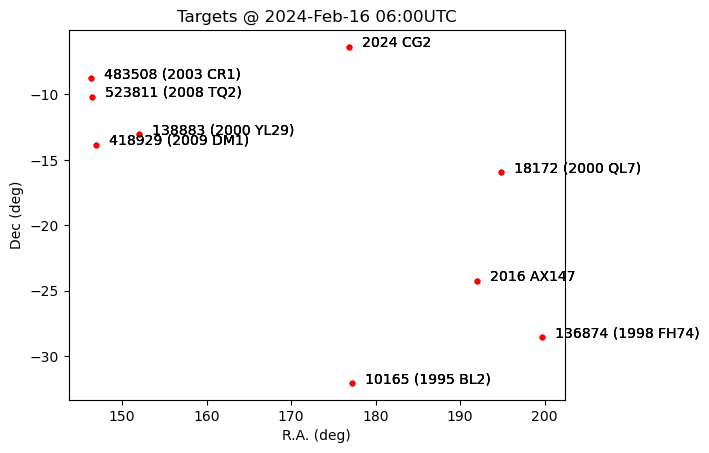

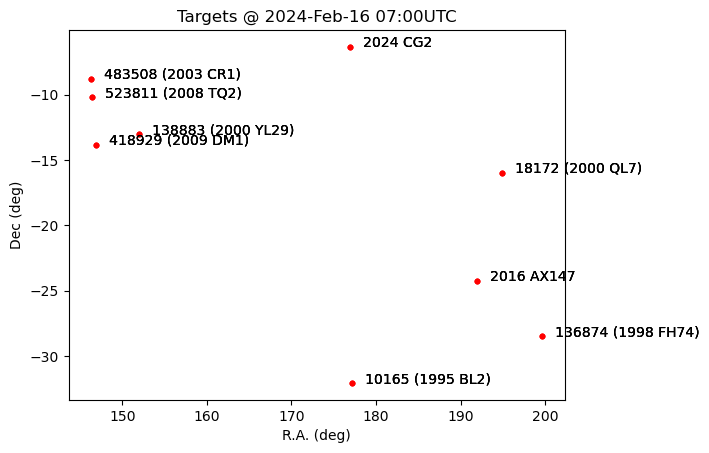

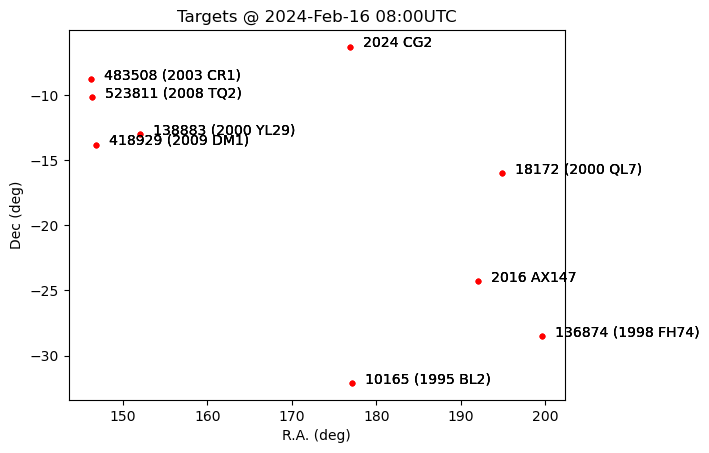

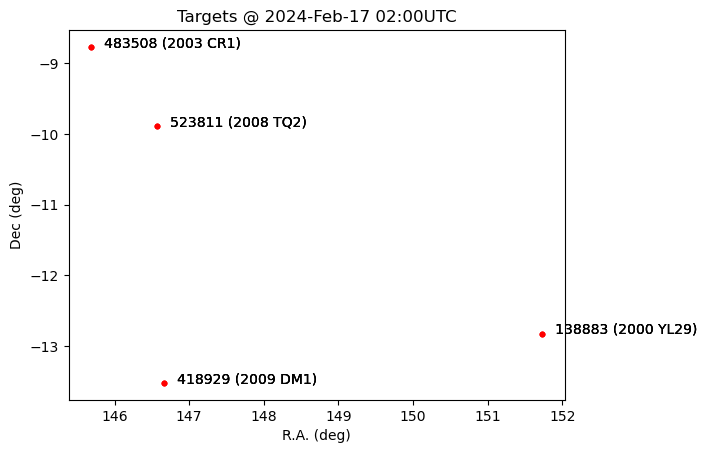

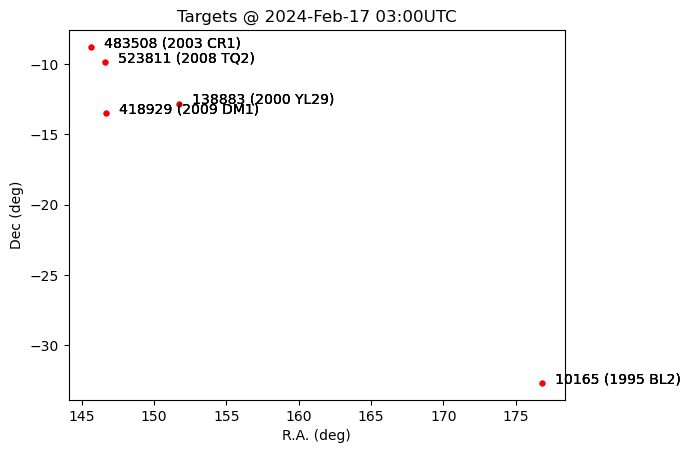

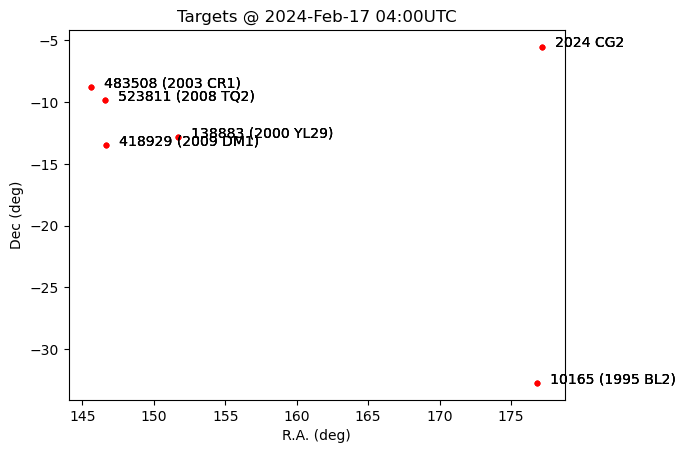

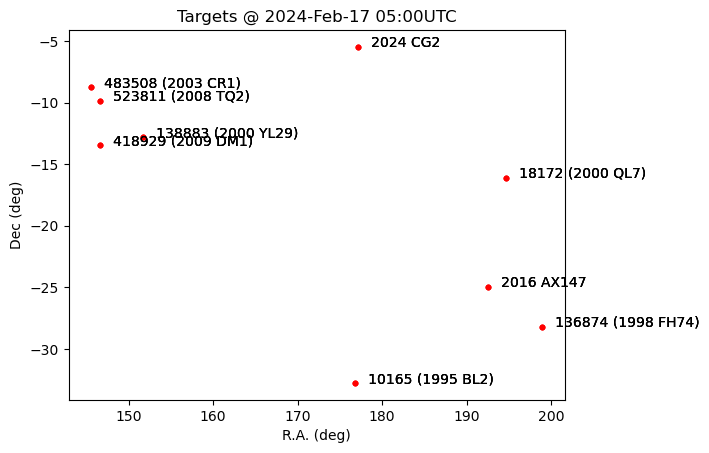

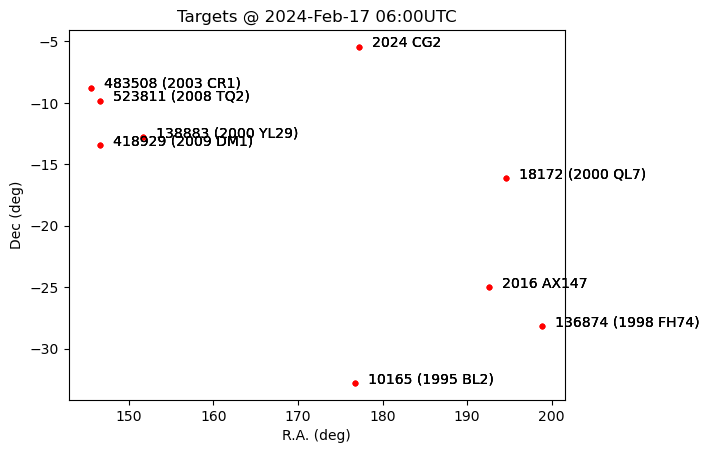

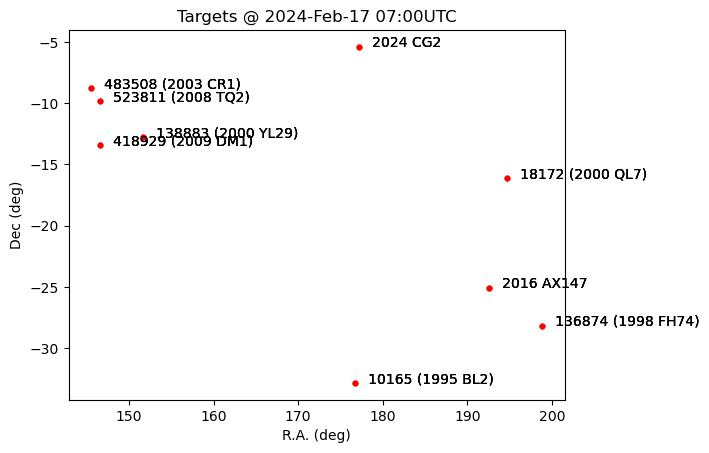

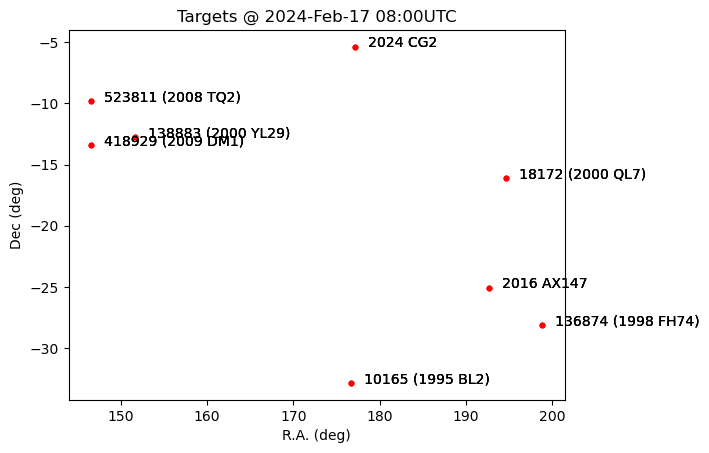

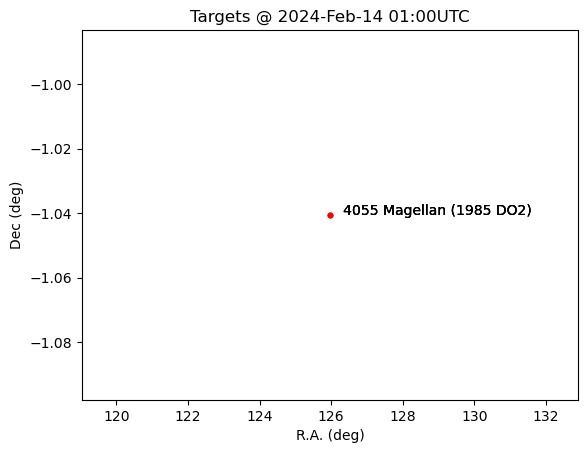

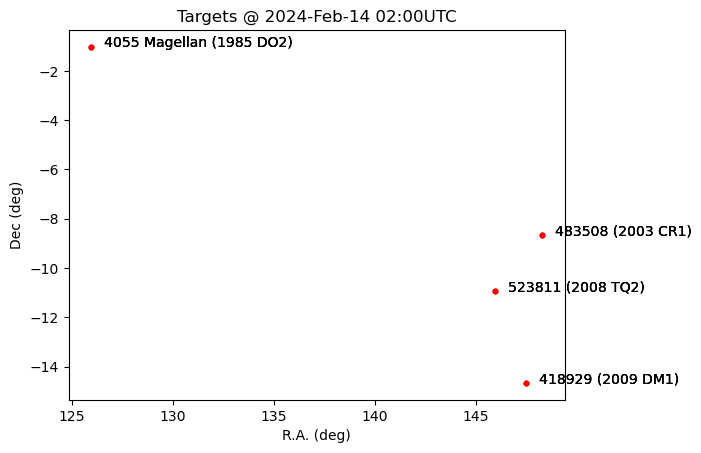

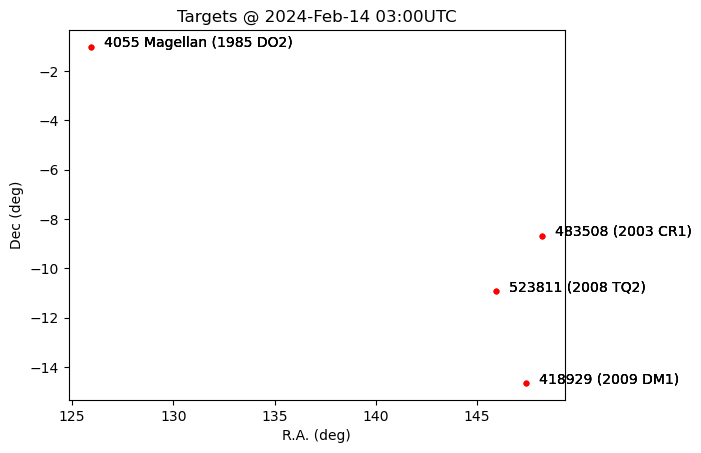

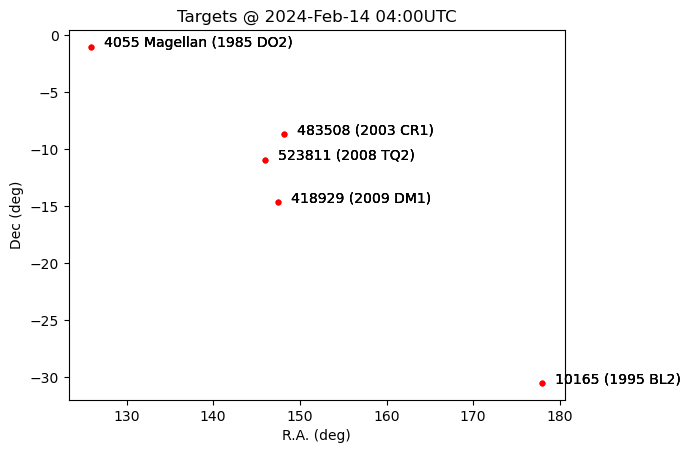

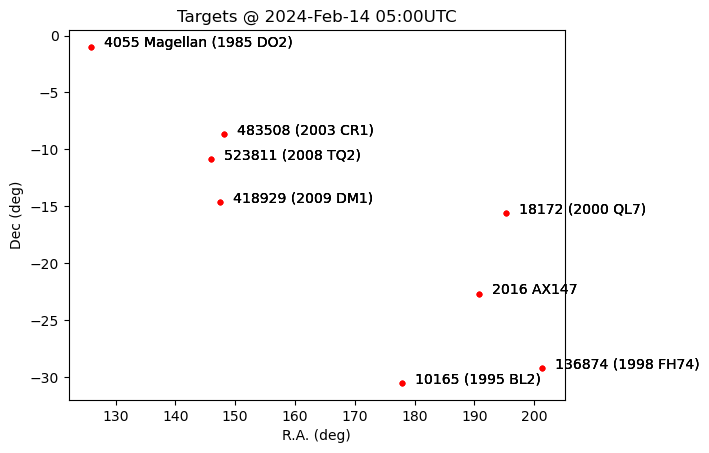

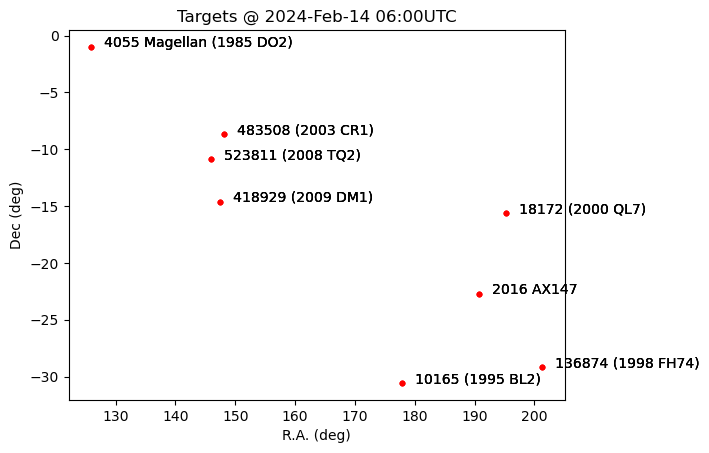

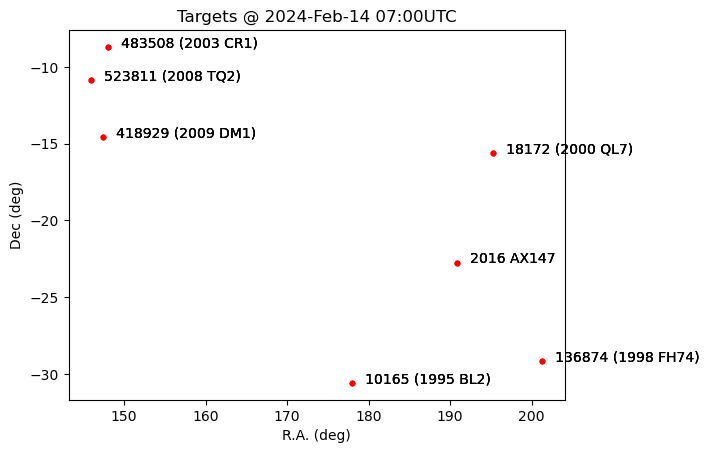

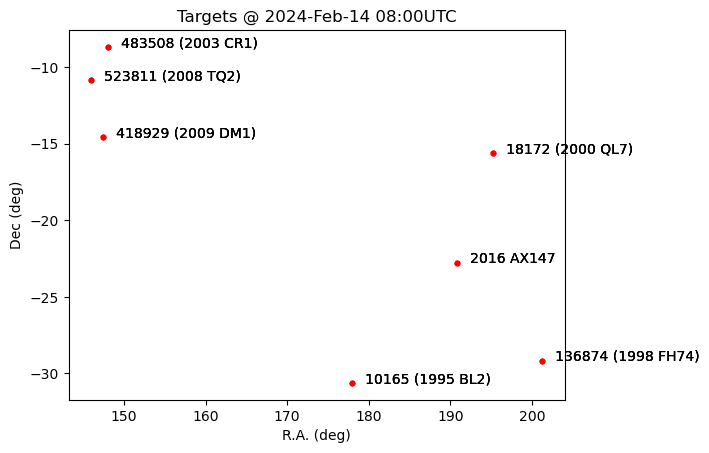

In [248]:
import glob
for night in glob.glob('night-*'):
    for hour in sorted(glob.glob(f'{night}/*UTC')):
        dfall = None
        for fn in glob.glob(f'{hour}/*.txt'):
            print(fn)
            df = pd.read_csv(fn, sep=r'\s+', header=0, skiprows=1, names=["ra", "dec", "Nexp", "ExpTime", "Filter"])
            df["targetname"] = fn.split('/')[-1].split('.')[0]
            if dfall is None:
                dfall = df
            else:
                dfall = pd.concat([dfall, df])
                
        # convert strings to (ra, dec)
        pos = SkyCoord(ra=dfall['ra'].values, dec=dfall['dec'].values, unit=(u.hourangle, u.deg))
        dfall["ra_deg"] = ra = pos.ra.degree
        dfall["dec_deg"] = dec = pos.dec.degree

        # plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(ra, dec, color = 'red', s=10)
        for x, y, txt in zip(ra, dec, dfall["targetname"]):
            ax.annotate('   ' + txt, (x, y))
        ax.set_xlabel("R.A. (deg)")
        ax.set_ylabel("Dec (deg)")
        ax.set_title("Targets @ " + hour.split('/')[-1].replace('_', ' '))

        # save
        fn = f'{hour}/targets.png'
        print(fn)
        fig.savefig(fn)
#        print(dfall)